In [28]:
import matplotlib.pyplot as plt
import numpy as np
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn import model_selection

%matplotlib inline

Урок 5. Случайный лес.

### 1. Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).

In [29]:
# Сгенерируем данные

classification_data, classification_labels = datasets.make_classification(
    n_samples=100,
    n_features = 2,
    n_informative = 2,
    n_classes = 2,
    n_redundant=0,
    n_clusters_per_class=1,
    random_state=5
)

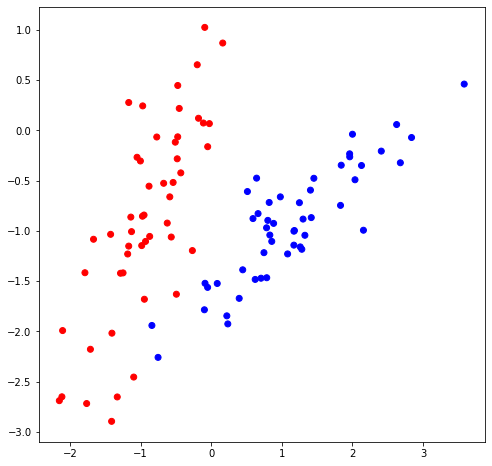

In [30]:
# Визуализируем сгенерированные данные 
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(classification_data[:,0], classification_data[:,1], c=classification_labels, cmap=colors)
plt.show()


PLEASE IGNORE THE CELL BELOW

In [31]:
#find_best_split   PLEASE IGNORE
data= classification_data
for index in range(1):
    t_values = [row[index] for row in data] # значение строки(row) по признаку(index)
    t= [row for row in data]
print("T_values",t_values[:5],"\n")
print("Data",data[:5])
print("row",t[:5])



T_values [-0.48221701522338245, 1.4174715917700609, 0.8837886859202346, 0.7469239043288685, -0.11161924805848533] 

Data [[-0.48221702 -0.28206699]
 [ 1.41747159 -0.86709816]
 [ 0.88378869 -0.92475428]
 [ 0.7469239  -1.2160026 ]
 [-0.11161925  0.07390672]]
row [array([-0.48221702, -0.28206699]), array([ 1.41747159, -0.86709816]), array([ 0.88378869, -0.92475428]), array([ 0.7469239, -1.2160026]), array([-0.11161925,  0.07390672])]


In [32]:
# Получение N бутстрап-выборок

random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

Есть некоторые практически рекомендации по построению случайных лесов: в задачах классификации рекомендуется брать $m = \sqrt{d}$, где $d$ - общее число признаков, и строить дерево до тех пор, пока в каждом листе не останется по одному объекту, а в задаче регрессии принимать $m = d/3$ и строить дерево, пока в листьях не останется по пять объектов.

$m = \sqrt{d}$ c использованием метода shuffle

In [33]:
#𝑚=V𝑑

def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)  # перемишаем наши признаки местами
    subsample = sample_indexes[0:len_subsample].copy()
#     for _ in range(len_subsample):
#         subsample.append(sample_indexes.pop())
        
    return subsample

In [34]:
# Класс узла
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [35]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get) #  # classes.get returns dictionary's value
        return prediction

ВОПРОС:

In [36]:
#Вопрос: Вы можете обязнить логику данной процедуры, интуитивно понимаю но не совсем
#           for label in self.labels:
#             if label not in classes:
#                 classes[label] = 0
#             classes[label] += 1
#              prediction = max(classes, key=classes.get) '''

В качестве функции оценки качества разбиения используется критерий Джини, который также может быть записан как

$$H(X) = 1 - \sum^{K}_{k=1}p_{k}^{2}.$$

In [37]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [38]:
# Расчет качества  (провеоим, надо ли создавать ещё одно поддерево)

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [39]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)  # TRUE 
    right = np.where(data[:, index] > t)  # FALSE over the t limit 
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [40]:
# Нахождение наилучшего разбиения f

def find_best_split(data, labels): 
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса(признака) из подвыборки длиной sqrt(n_features) - кол признаков
    subsample = get_subsample(n_features)
    
    for index in subsample:
        t_values = [row[index] for row in data] # row gives rows and row[index(colname)] gets value
                    # merges 0 and 1 columns into a single column
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [41]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [42]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:    # добавляем перемешанные данные из boostrap
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [43]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):   # node and Class Node are not the same thing
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [44]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [45]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [46]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [47]:
# Методы для визуализации данных и дерева на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

def draw_dataset(train_data, train_labels, test_data, test_labels, forest):
    plt.figure(figsize = (10, 4))

    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

    # график обучающей выборки
    plt.subplot(1,2,1)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title('Обучающая выборка')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title('Тестовая выборка')

    plt.show()

В методе построения графика обучаем набор даных (все точки в пространстве признаков) на полученном случайном лесе. Разобьем исходную выборку на тренировочную и тестовую и построим разделяющую гиперплосколсть при разных количествах деревьев в случайном лесе.

In [48]:
#  Выборка обучающая и тестовая
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(
    classification_data, 
    classification_labels,
    test_size = 0.3,
    random_state = 1
)


Число деревьев в случайном лесе: 	1
Точность обучающей выборки: 	87.14285714285714
Точность тестовой выборки: 	86.66666666666667


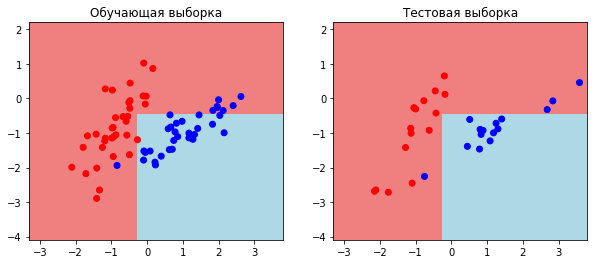


Число деревьев в случайном лесе: 	3
Точность обучающей выборки: 	95.71428571428572
Точность тестовой выборки: 	90.0


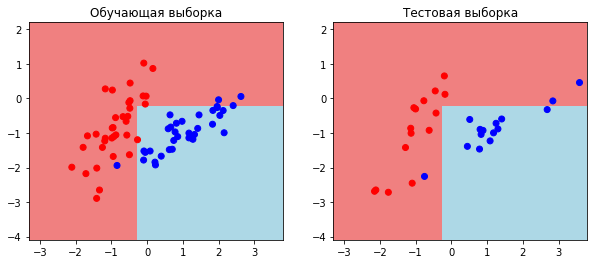


Число деревьев в случайном лесе: 	10
Точность обучающей выборки: 	98.57142857142858
Точность тестовой выборки: 	93.33333333333333


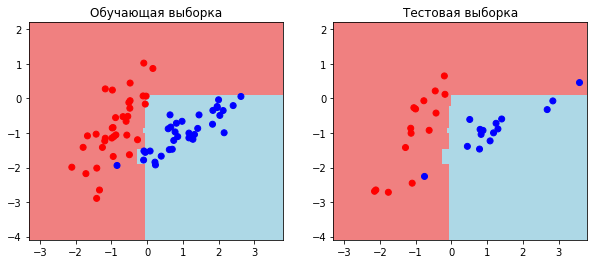


Число деревьев в случайном лесе: 	50
Точность обучающей выборки: 	98.57142857142858
Точность тестовой выборки: 	96.66666666666667


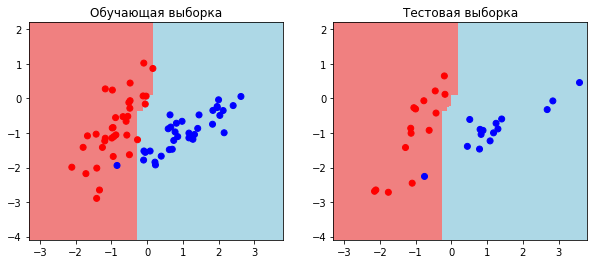

In [49]:
for n_trees in [1, 3, 10, 50]:
    # обучение
    my_forest = random_forest(train_data, train_labels, n_trees)

    # предсказание
    train_answers = tree_vote(my_forest, train_data)
    test_answers = tree_vote(my_forest, test_data)

    # параметры точности
    train_accuracy = accuracy_metric(train_labels, train_answers)
    test_accuracy = accuracy_metric(test_labels, test_answers)

    print(f'\nЧисло деревьев в случайном лесе: \t{n_trees}\nТочность обучающей выборки: \t{train_accuracy}\nТочность тестовой выборки: \t{test_accuracy}')

    draw_dataset(train_data, train_labels, test_data, test_labels, my_forest)

### 2. Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

Выводы
*  Увеличение числа деревьев в случайном лесе приводит к усложнению формы гиперплоскости
*  Точность тестовой выборки не сильно меняется при изменение количество деревьев.
*  Могу сказать что с использованием random_forest функции мы себя обезопасили от переобучение данной модели.

Индекс Джини:
$$H(X) = \sum_{k=1}^K p_k(1 - p_k)$$

Энтропия Шеннона:
$$H(X) = -\sum_{k=1}^K p_k\log_2p_k$$

Дисперсионный критерий:
$$H(X) = \frac{1}{X}\sum_{i\in{X}}(y_i - \overline{y}(X))^2$$

Дисперсионный критерий используется в задачах регрессии, критерий Джени и энтропийный критерий Шеннона используются в задачах классификации.

In [ ]:
# # Расчет критерия Джини

# def gini(labels):
#     #  подсчет количества объектов разных классов
#     classes = {}
#     for label in labels:
#         if label not in classes:
#             classes[label] = 0
#         classes[label] += 1
    
#     #  расчет критерия
#     impurity = 1     # "impurity" - "нечистота", степень неопределенности
#     for label in classes:
#         p = classes[label] / len(labels)
#         impurity -= p ** 2
        
#     return impurity

In [57]:
# Расчет энтропийного критерия Шеннона

def calc_entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 0    
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p * np.log2(p)          # gini   impurity -= p ** 2
        
    return impurity

Переопределим метод вычисления функционала качества и метод нахождения наилучшего разбиения так, чтобы они использовали энтропийный критерий Шеннона в качестве критерия информативности.

In [58]:
# # Расчет качества

# def quality(left_labels, right_labels, current_gini):

#     # доля выборки, ушедшей в левое поддерево
#     p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
#     return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [60]:
# Расчет качества с использованием энтропии Шеннона

def quality(left_labels, right_labels, current_entropy):

    # доля выборки, ушедшей в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_entropy - p * calc_entropy(left_labels) - (1 - p) * calc_entropy(right_labels)